<a href="https://colab.research.google.com/github/hansbrunner/safety_data/blob/main/Clozapine/Clozapine_adverse_events.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
In this analysis, I aim to explore the use of data analysis techniques within the field of drug safety surveillance.
Specifically, I am interested in understanding how adverse events related to medical drugs are reported and monitored.
This is a crucial area for ensuring the safety of medications.

For this project, I have chosen to focus on Clozapine, an antipsychotic drug commonly used to treat schizophrenia.
Clozapine is known for its efficacy but also for its potential to cause a wide range of adverse events.
The goal of this analysis is to gain insights into the types of adverse events reported for Clozapine and explore
trends in the data using information from the FDA Adverse Event Reporting System (FAERS).

In this notebook, I will focus on the following objectives:

Characterizing reported adverse events: Identifying the most commonly reported adverse events associated with Clozapine.
Demographic analysis: Examining whether certain demographic groups (age, gender) are more affected by specific adverse events.

By working through this analysis, I hope to develop a deeper understanding of the real-world data related to drug safety and
enhance my skills in working with large datasets, especially those used in pharmacovigilance.
"""


In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')


In [ ]:
# Navigate to file
%cd /content/drive/MyDrive/Colab Notebooks/Clozapine
from my_functions import fetch_fda_data, extract_fda_data

# Fetch data from FDA
data = fetch_fda_data("clozapine", 10000) # This takes a while (few minutes)

# Convert list of json to pandas df
df = extract_fda_data(data)

# Read PT-to-SOC mapping file generated in "Convert_AE_PT_to_SOC_Clozapine"
map_df = pd.read_csv("pt_soc_mapping.csv",index_col=0) #

# Rename nan SOCs to 'Undefined'
map_df['SOC_normalized'].fillna('Undefined', inplace=True)

# Rename and remove columns
map_df.drop(columns=['SOC'], inplace=True)
map_df.rename(columns={'SOC_normalized': 'SOC'}, inplace=True)

/content/drive/MyDrive/Colab Notebooks/Clozapine


<ipython-input-9-1bbb4b255907>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  map_df['SOC_normalized'].fillna('Undefined', inplace=True)


In [ ]:
# Make overview table: gender, age, and outcome for reports. Note that each patient can have multiple reports
import numpy as np
from collections import defaultdict

# Outcome labels
outcome_labels = {
    '1': 'Recovered/Resolved',
    '2': 'Recovering/Resolving',
    '3': 'Not Recovered/Not Resolved',
    '4': 'Recovered/Resolved with Sequelae',
    '5': 'Fatal',
    '6': 'Unknown'
}

# Gender counter
gender_counts = {'Male': 0, 'Female': 0, 'Unknown': 0}

# Age counter
age_counts = {
    'Less than 18': 0,
    '18-30': 0,
    '31-50': 0,
    '51-75': 0,
    'Above 75': 0,
    'Unknown': 0
}
outcome_counts = defaultdict(int)

# Report counter
total_reports = 0

# Loop through the DataFrame
for _, report in df.iterrows():

    # Get gender
    gender = report.get('Gender', 'Unknown')
    gender_counts[gender] += 1

    # Get age and categorize it
    age = report.get('Age', "Unknown")
    if age != "Unknown":
        age = int(age)
        if age < 18:
            age_label = 'Less than 18'
        elif 18 <= age <= 30:
            age_label = '18-30'
        elif 31 <= age <= 50:
            age_label = '31-50'
        elif 51 <= age <= 75:
            age_label = '51-75'
        elif age > 75:
            age_label = 'Above 75'
    else:
        age_label = 'Unknown'
    age_counts[age_label] += 1

    # Get outcome
    outcome = report.get('Outcome', '6')
    outcome_label = outcome_labels.get(outcome, 'Unknown')
    outcome_counts[outcome_label] += 1

    # Update report counter
    total_reports += 1

# Calculate percentages
def calculate_percentages(category_counts):
    return {key: (value, (value / total_reports) * 100) for key, value in category_counts.items()}

# Create DataFrames for Gender, Age, and Outcome
gender_df = pd.DataFrame.from_dict(calculate_percentages(gender_counts), orient='index', columns=['Count', 'Percentage'])
age_df = pd.DataFrame.from_dict(calculate_percentages(age_counts), orient='index', columns=['Count', 'Percentage'])
outcome_df = pd.DataFrame.from_dict(calculate_percentages(outcome_counts), orient='index', columns=['Count', 'Percentage'])

# Reorder outcome df for better display
outcome_df = outcome_df.reindex([
    'Recovered/Resolved',
    'Recovering/Resolving',
    'Not Recovered/Not Resolved',
    'Recovered/Resolved with Sequelae',
    'Fatal',
    'Unknown'
])

# Display results using pretty formatting
display(gender_df.style.format({"Percentage": "{:.2f}%"}).set_caption("Gender Distribution"))
display(age_df.style.format({"Percentage": "{:.2f}%"}).set_caption("Age Distribution"))
display(outcome_df.style.format({"Percentage": "{:.2f}%"}).set_caption("Outcome Distribution"))

,Count,Percentage
Male,20018,57.39%
Female,12156,34.85%
Unknown,2704,7.75%


,Count,Percentage
Less than 18,680,1.95%
18-30,3682,10.56%
31-50,10430,29.90%
51-75,10261,29.42%
Above 75,1093,3.13%
Unknown,8732,25.04%


,Count,Percentage
Recovered/Resolved,7213,20.68%
Recovering/Resolving,2384,6.84%
Not Recovered/Not Resolved,4259,12.21%
Recovered/Resolved with Sequelae,125,0.36%
Fatal,2811,8.06%
Unknown,18086,51.86%


In [ ]:
# Append SOCs based on PT
map_df.rename(columns={'PT': 'AE PT'}, inplace=True)
df = pd.merge(df, map_df, on='AE PT', how='left')
print(df.head())

   Patient #                             AE PT Outcome Age Gender Report Date  \
0          1        Neutrophil count increased       6  46   Male    20150819   
1          1  White blood cell count increased       3  46   Male    20150819   
2          1                Abnormal behaviour       6  46   Male    20150819   
3          2              Atrial septal defect       1  19   Male    20140522   
4          2         Bundle branch block right       1  19   Male    20140522   

  Drug Name Indication for Use              Report Type Treatment Start Date  \
0  CLOZARIL      SCHIZOPHRENIA  Healthcare Professional             20110613   
1  CLOZARIL      SCHIZOPHRENIA  Healthcare Professional             20110613   
2  CLOZARIL      SCHIZOPHRENIA  Healthcare Professional             20110613   
3  CLOZARIL      SCHIZOPHRENIA  Healthcare Professional             20140227   
4  CLOZARIL      SCHIZOPHRENIA  Healthcare Professional             20140227   

                                

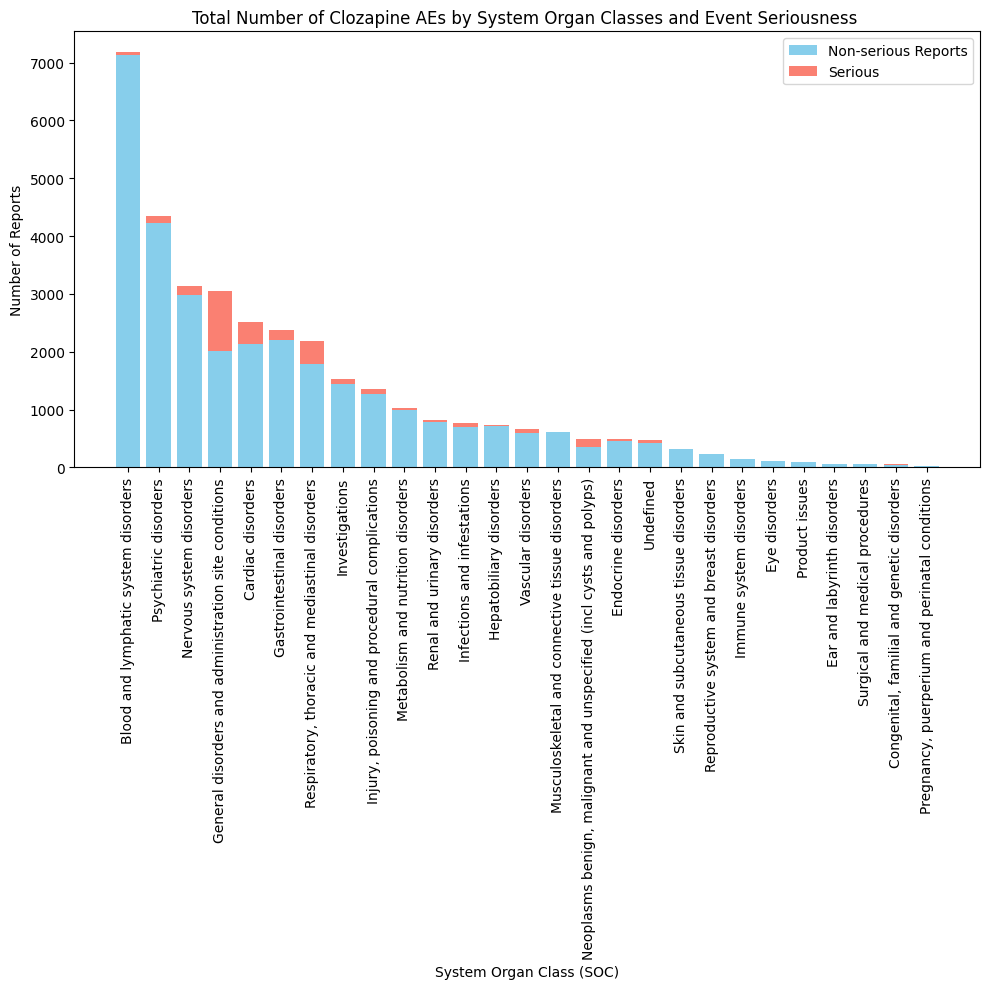

In [ ]:
# plot reported AEs and severity (as SOC)
import matplotlib.pyplot as plt

# Define severe outcomes
severe_outcomes = {'4', '5'}  #  4 = Recovered with Sequelae, 5 = Fatal

# Mark severe reports
df['Severe'] = df['Outcome'].isin(severe_outcomes)

# Group the data by SOC and count total and severe reports
soc_grouped = df.groupby('SOC').agg(
    total_reports=('Patient #', 'size'),
    severe_reports=('Severe', 'sum')
).reset_index()

# Calculate non-severe reports (for stacking)
soc_grouped['non_severe_reports'] = soc_grouped['total_reports'] - soc_grouped['severe_reports']
soc_grouped = soc_grouped.sort_values(by='total_reports', ascending=False) # Sort

# Plot
plt.figure(figsize=(10, 10))

# Plot non-severe reports (bottom of the bar)
plt.bar(soc_grouped['SOC'], soc_grouped['non_severe_reports'], label='Non-serious Reports', color='skyblue')

# Plot severe reports (stacked on top of non-severe reports)
plt.bar(soc_grouped['SOC'], soc_grouped['severe_reports'], bottom=soc_grouped['non_severe_reports'], label='Serious', color='salmon')

# Add labels and title
plt.xlabel('System Organ Class (SOC)')
plt.ylabel('Number of Reports')
plt.title('Total Number of Clozapine AEs by System Organ Classes and Event Seriousness ')
plt.xticks(rotation=90)
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

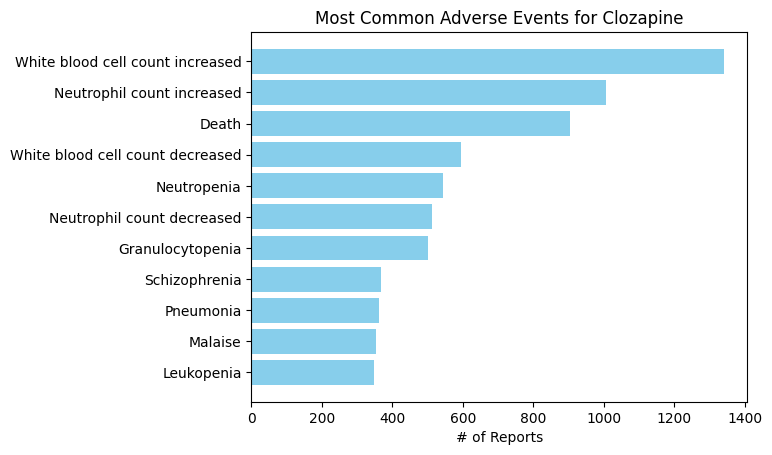

In [ ]:
# plot most common PT AE for clozapine
cut_off = df.shape[0] * 0.01 # cut off of 1 percent

# count number of reports for each PT AE
pt_grouped = df.groupby('AE PT').agg(
    total_reports=('Patient #', 'size')
).reset_index()
pt_grouped.sort_values(by='total_reports', ascending=False,inplace=True) # sort
pt_grouped = pt_grouped.loc[pt_grouped["total_reports"]>cut_off]

# Plot a bar chart for the counts of adverse events in PT
plt.figure()
plt.barh(pt_grouped['AE PT'], pt_grouped['total_reports'], color='skyblue')
plt.xlabel('# of Reports')
plt.title('Most Common Adverse Events for Clozapine')
plt.gca().invert_yaxis()  # Most common at the top
plt.show()

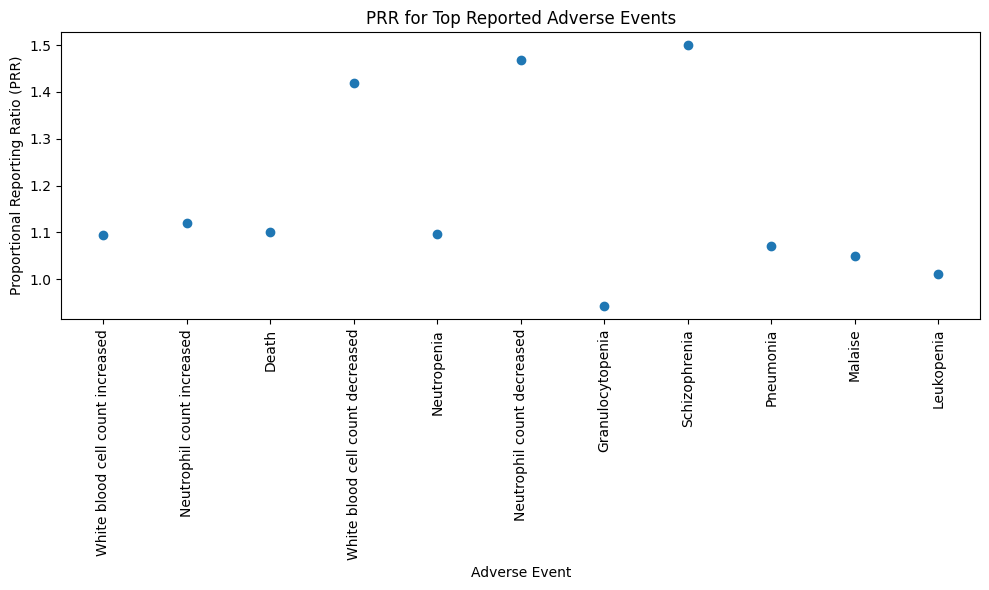

,AE,a,b,c,d,PRR,Chi-Square P-Value
0,White blood cell count increased,836,19182,464,11692,1.094103,0.119415
1,Neutrophil count increased,633,19385,343,11813,1.120675,0.090442
2,Death,566,19452,312,11844,1.101620,0.174801
3,White blood cell count decreased,381,19637,163,11993,1.419408,0.000178
4,Neutropenia,269,19749,149,12007,1.096317,0.392048
5,Neutrophil count decreased,319,19699,132,12024,1.467529,0.000210
6,Granulocytopenia,295,19723,190,11966,0.942841,0.554880
7,Schizophrenia,242,19776,98,12058,1.499544,0.000755
8,Pneumonia,210,19808,119,12037,1.071624,0.583030
9,Malaise,216,19802,125,12031,1.049334,0.707893


In [ ]:
import seaborn as sns
import numpy as np
from my_functions import calculate_prr_chi2
import scipy.stats as stats

# remove Unknown gender
gender_df = df.copy()
gender_df = gender_df[gender_df['Gender'] != 'Unknown']

# get top AEs
aes = list(pt_grouped['AE PT'])

# get prr and chi-square
results = calculate_prr_chi2(gender_df, 'Male', aes) # Male as reference

# Plot PPR
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(aes)),results["PRR"])
plt.gca().set_xticks(np.arange(len(aes)), aes, rotation=90)
plt.title('PRR for Top Reported Adverse Events')
plt.xlabel('Adverse Event')
plt.ylabel('Proportional Reporting Ratio (PRR)')
plt.tight_layout()
plt.show()

# pretty table
display(results.style.set_caption("AE gender comparison"))



In [ ]:

"""In my analysis of Clozapine-related adverse events, I found that both increased and decreased white blood cell (WBC)
counts and neutrophil counts are commonly reported. These fluctuations in WBC and neutrophil levels are likely
related to Clozapine's known risk of agranulocytosis, a severe reduction in WBCs that increases infection risk.
Monitoring both WBC and neutrophil counts is crucial for Clozapine patients to manage the risk of hematological complications.
My analysis suggests that the reporting of blood-related side effects, specifically decreased white blood cells and decreased neutrophils,
is disproportionately higher in men than in women. However, it is important to note that this finding reflects
disproportionality in reporting and does not directly suggest that men are at a higher absolute risk of these AEs.
Important to note is no difference for Neutropenia, Granulocytopenia and Leukopenia.
"""

"In my analysis of Clozapine-related adverse events, I found that both increased and decreased white blood cell (WBC)\ncounts and neutrophil counts are commonly reported. These fluctuations in WBC and neutrophil levels are likely\nrelated to Clozapine's known risk of agranulocytosis, a severe reduction in neutrophils that increases infection risk.\nHowever, Clozapine has also been associated with leukocytosis, a condition where WBC levels are elevated. \nMonitoring both WBC and neutrophil counts is crucial for Clozapine patients to manage the risk of hematological complications.\nMy analysis suggests that gender may influence the occurrence of these blood-related side effects, \nwith males potentially being at higher risk. \nImportant to consider is that this analysis does not account for indication, seriousness, age, duration of taking drug, and other relevant factors.\nNext, I will do multivariate logistic regression, to adjust for age"

In [ ]:
# Multivariate logistic regression
import statsmodels.api as sm
def logistic_regression_ae(df, aes):
    results = []

    # Binary variable for gender (1 = Male, 0 = Female)
    df['Gender_Male'] = df['Gender'].apply(lambda x: 1 if x == 'Male' else 0)

    for ae in aes:
        # Create a binary variable: 1 if the AE occurred, 0 otherwise
        df[f'{ae}_binary'] = df['AE PT'].apply(lambda x: 1 if x == ae else 0)

        # Define the independent variables (constant, age, and gender)
        X = df[['Age', 'Gender_Male']]
        X = sm.add_constant(X)  # Adds the intercept term

        # Dependent variable
        y = df[f'{ae}_binary']

        # Fit logistic regression
        logit_model = sm.Logit(y, X)
        result = logit_model.fit(disp=False)

        # Extract metrics
        odds_ratios = np.exp(result.params)  # Convert coefficients to odds ratios
        conf = np.exp(result.conf_int())     # Confidence intervals for the odds ratios
        p_values = result.pvalues            # p-values

        # Append the results for each AE
        results.append({
            'AE': ae,
            'Odds Ratio (Age)': odds_ratios['Age'],
            'Odds Ratio (Gender)': odds_ratios['Gender_Male'],
            'p-value (Age)': p_values['Age'],
            'p-value (Gender)': p_values['Gender_Male'],
            '95% CI (Age)': conf.loc['Age'].values,
            '95% CI (Gender)': conf.loc['Gender_Male'].values
        })

    return pd.DataFrame(results)

In [ ]:
gender_df = df.copy()
gender_df = gender_df[gender_df['Gender'] != 'Unknown']

# get top AEs
aes = list(pt_grouped['AE PT'])

# Fix age
gender_df['Age'] = pd.to_numeric(gender_df['Age'], errors='coerce') # non-numeric values will be set to NaN

# Only include ages between 18 and 75
gender_df = gender_df[(gender_df['Age'] >= 18) & (gender_df['Age'] <= 75)]

# Get metrics from logistic regression
results = logistic_regression_ae(gender_df, aes) # Male as reference

# Display table with results from logistic regression
display(results.style.set_caption("AE Logistic Regression"))

,AE,Odds Ratio (Age),Odds Ratio (Gender),p-value (Age),p-value (Gender),95% CI (Age),95% CI (Gender)
0,White blood cell count increased,0.994377,1.072499,0.007996,0.255859,[0.99024148 0.99852914],[0.95052409 1.21012717]
1,Neutrophil count increased,1.004077,1.131088,0.096438,0.083359,[0.9992719 1.00890525],[0.98387986 1.30032064]
2,Death,1.050455,1.376558,0.000000,0.001182,[1.04290212 1.05806251],[1.13479283 1.66983164]
3,White blood cell count decreased,0.998707,1.537103,0.697567,0.000028,[0.99220837 1.00524727],[1.2571273 1.87943304]
4,Neutropenia,1.002187,1.085228,0.558938,0.449815,[0.99487231 1.00955459],[0.8778037 1.34166702]
5,Neutrophil count decreased,0.992814,1.454471,0.048090,0.000764,[0.98574002 0.9999394 ],[1.16937998 1.80906677]
6,Granulocytopenia,0.996607,0.921879,0.332567,0.415373,[0.98977943 1.00348199],[0.75799156 1.12120044]
7,Schizophrenia,0.977863,1.351273,0.000308,0.103238,[0.96604569 0.98982421],[0.9407428 1.94095494]
8,Pneumonia,1.036982,1.197482,0.000000,0.190975,[1.02680509 1.04725881],[0.91403022 1.56883466]
9,Malaise,0.996321,1.185975,0.459901,0.245193,[0.98662927 1.006108 ],[0.8894924 1.58128085]


In [ ]:
"""
The logistic regression analysis suggests that men are disproportionately more likely to report decreases
in white blood cell (WBC) counts and neutrophil counts compared to women when taking Clozapine.
However, there was no significant gender difference in the reporting of more severe hematological
adverse events such as neutropenia, leukopenia, and granulocytopenia, which are reported at similar rates by both genders.
Importantly, these findings are based on patients that report AEs, and not based on the population using Clozapine.

Important Considerations: This analysis is based on a subset of 10,000 reports from the FDA's adverse event reporting system
and does not account for several important factors that could influence the findings.
These include the indication for which Clozapine was prescribed (such as schizophrenia or treatment-resistant psychosis),
the seriousness of the adverse events reported, the duration of Clozapine use, concomitant medications,
and the patients' underlying health conditions. Additionally, factors such as dose variations,
compliance with treatment, and individual patient characteristics (e.g., genetic predisposition or lifestyle factors)
were not considered in this analysis. These variables could play significant roles in determining the risk and severity of adverse events.
Future studies incorporating these factors would provide a more comprehensive understanding of the safety profile of Clozapine across different patient populations.

In conclusion, these findings are consistent with the safety profile of Clozapine,
particularly its association with hematological adverse effects such as leukopenia and neutropenia,
reinforcing the need for regular blood monitoring to minimize these risks.

I will end with a plot of the frequency of the most common AEs below - again, this is not based on patient taking Clozapine, but from AE reports.
"""

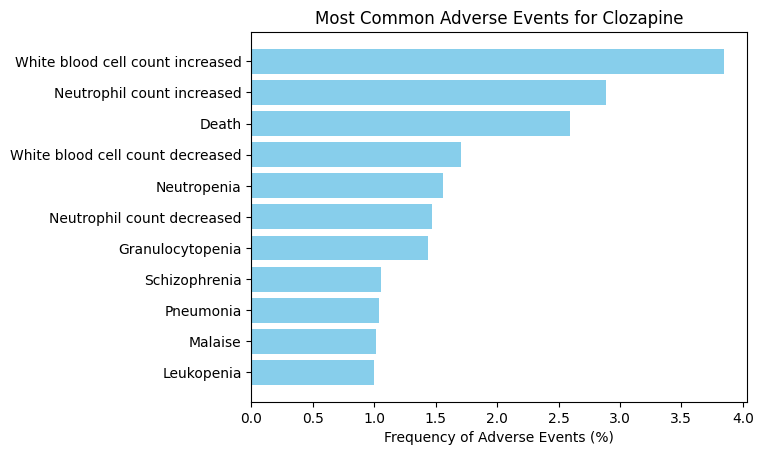

In [ ]:
# plot most common PT AE for clozapine
cut_off = df.shape[0] * 0.01 # cut off of 1 percent

# count number of reports for each PT AE
pt_grouped = df.groupby('AE PT').agg(
    total_reports=('Patient #', 'size')
).reset_index()
pt_grouped.sort_values(by='total_reports', ascending=False,inplace=True) # sort
pt_grouped = pt_grouped.loc[pt_grouped["total_reports"]>cut_off]

# Convert to percentage
pt_grouped['percentage_reports'] = (pt_grouped['total_reports'] / total_reports) * 100

# Plot a bar chart for the counts of adverse events in PT
plt.figure()
plt.barh(pt_grouped['AE PT'], pt_grouped['percentage_reports'], color='skyblue')
plt.xlabel('Frequency of Adverse Events (%)')
plt.title('Most Common Adverse Events for Clozapine')
plt.gca().invert_yaxis()  # Most common at the top
plt.show()